# Outlier Detection with Cleaned Dataset
We’ll use **`cleaned_dataset.csv`**, which has intentional outliers in numeric columns:

- `income`: extreme high values planted as outliers
- `score`: corrupted values (negative or >100)

This lets us demonstrate:
- **Univariate detection** (IQR, z-scores) on `income` and `score`
- **Rule-based detection** (flag impossible values like negative scores)
- **Multivariate detection** (optional: clustering on `age` vs `income`)


# Outlier Detection: From IQR and Z-scores to K-means distance

**Goal:** learn quick, explainable methods to flag outliers, and a clustering-based approach for messy cases.

## 1. Rule-based Detection (Score sanity checks)
Some columns have *hard logical limits* rather than distribution-based limits.

**Example:**
- `score` should be between 0 and 100 (like a percentage/grade scale)
- Any value outside this range is automatically an outlier

This shows how domain rules complement statistical detection.


In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set paths
ROOT_ = os.getcwd()
DATA_  = os.path.join(ROOT_, "data")

# Obtain all CSV file paths in the data directory
csv_paths = glob.glob(os.path.join(DATA_, "*.csv*"))
assert len(csv_paths) > 0, f"No CSV files found in {DATA_}"

In [3]:
# Load cleaned dataset from pandas_basics
data_name = "cleaned"
path = [path for path in csv_paths if data_name in path][0]
df_cleaned_dataset = pd.read_csv(path)

In [10]:
# Rule-based detection for `score` and income
bad_scores = df_cleaned_dataset[(df_cleaned_dataset['score'] < 0) | (df_cleaned_dataset['score'] > 100)]
bad_income = df_cleaned_dataset[df_cleaned_dataset['yearly_income'] < 0]

if not bad_income.empty:
    print("Out-of-range values detected for income:")
    print(bad_income[['yearly_income']].head())

if not bad_scores.empty:
    print("\nOut-of-range values detected for score:")
    print(bad_scores[['score']].head())

Out-of-range values detected for income:
     yearly_income
137       -4726.19

Out-of-range values detected for score:
     score
24   150.0
27   150.0
64   -10.0
214  150.0
243  150.0


## 2. Visual Observations
- Box plots and histograms to see tails
- Scatter to check suspicious clusters or isolated points

> Exercise: plot hist + box for 2–3 columns, and mark the suspected outliers.


Unique values in 'category' column:
yearly_income
71544.53    1
58903.32    1
51817.67    1
48668.05    1
70558.11    1
           ..
32897.59    1
65452.93    1
54644.30    1
27724.17    1
42488.83    1
Name: count, Length: 516, dtype: int64


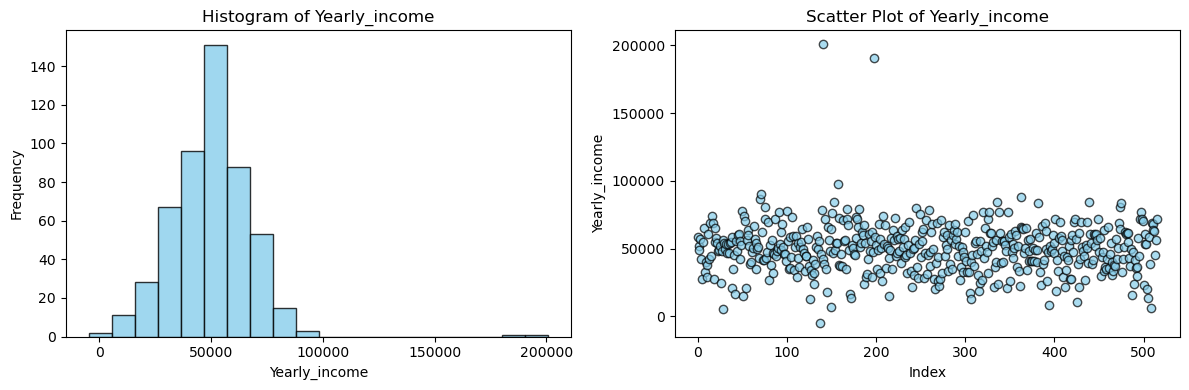

In [11]:
# Print unique values for a specific column and its value counts
column = 'yearly_income'
print(f"\nUnique values in 'category' column:\n{df_cleaned_dataset[column].value_counts(dropna=False)}")

# Visualized
value_counts = df_cleaned_dataset[column].value_counts(dropna=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram with 20 bins
ax1.hist(df_cleaned_dataset[column], bins=20, color='skyblue', edgecolor='black', alpha=0.8)
ax1.set_xlabel(column.capitalize())
ax1.set_ylabel('Frequency')
ax1.set_title(f'Histogram of {column.capitalize()}')

# Scatter plot
ax2.scatter(df_cleaned_dataset.index, df_cleaned_dataset[column], alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Index')
ax2.set_ylabel(column.capitalize())
ax2.set_title(f'Scatter Plot of {column.capitalize()}')

plt.tight_layout()
plt.show()

## 3. IQR Rule (Univariate)
---
**Example column:** `income`

- Compute Q1, Q3, and IQR = Q3 - Q1
- Define fences: `[Q1 - 1.5*IQR, Q3 + 1.5*IQR]`
- Flag values outside as potential outliers

We’ll apply this to `df['income']` to highlight the planted extreme values.

In [22]:
# Obtain column values
column = df_cleaned_dataset['yearly_income'].to_numpy()

quartiles = np.percentile(column, [25, 75])
Q1, Q3 = quartiles
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nIQR Method: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")

outliers_iqr = df_cleaned_dataset[(column < lower_bound) | (column > upper_bound)]
print(f"\nIQR Method: Detected {len(outliers_iqr)} outliers in yearly_income.\n")
print(outliers_iqr.head())


IQR Method: Lower Bound = 7648.137500000008, Upper Bound = 91718.8375

IQR Method: Detected 7 outliers in yearly_income.

    first_name last_name  age  yearly_income  score      signup_datetime  \
28        John     Smith   84        5532.07  46.75  2020-01-24 08:23:00   
137      Steve     Brown   28       -4726.19  15.06  2021-04-13 15:48:00   
141       John     Jones   72      200895.09  17.67  2021-02-26 15:02:00   
150        Eve     Jones   15        6994.18  19.80  2022-06-19 23:00:00   
157        Eve     Brown   53       97682.81  12.72  2020-12-31 14:05:00   

    category    full_name full_name_normal full_name_concat  
28         B   John Smith       John Smith       John Smith  
137        C  Steve Brown      Steve Brown      Steve Brown  
141        A   John Jones       John Jones       John Jones  
150        B    Eve Jones        Eve Jones        Eve Jones  
157        A    Eve Brown        Eve Brown        Eve Brown  


## 4. Z-score (Univariate)
---
**Example column:** `income`

- Compute z = (x - mean)/std
- Flag values with |z| > 3

We’ll run this on `df['income']` to catch the extreme high outliers.
Later, try `df['score']` to see how corrupted values (e.g. -10, 150) are caught.

## 5. Robust Z via Median and MAD
- `mad = median(|x - median(x)|)` and `z_robust = 0.6745*(x - median)/mad`
- Flag `|z_robust| > k` (k ≈ 3.5 common)

**Pros:** resilient to heavy tails. **Cons:** like IQR, typically univariate.

## 6. Multivariate Angle: K-means Distance
- Fit K-means, compute distance of each point to its assigned centroid
- Points with distances in the extreme tail are candidates
- Choose K via the elbow method on SSE (sum of squared errors)

> Exercise: run K across a range, plot SSE vs K, pick elbow; then flag top 1% farthest points.

## 7. Practical Playbook
- Start univariate (IQR/robust-z) to catch obvious issues
- Move to multivariate (distance in embedding space, clustering) when needed
- Always review a sample of flagged points; never auto-drop without context
- After cleaning, re-check distribution and downstream metrics (training stability, convergence)

## 8. Reporting
- Summarize: how many flagged, by which rule, percent of data removed/edited
- Keep a reversible log of changes (row ids, old value → new value, reason)

**Takeaways**
- Use simple, explainable rules first.
- Robust methods reduce false alarms when data are skewed.
- Clustering distances align well with messy, multi-feature data.